In [1]:
import os
import S4
import numpy as np
import scipy.constants as consts
import scipy.integrate as intg
import matplotlib.pyplot as plt
%matplotlib notebook

# Infinite Half Slab

This is a test of S4, comparing it to analytical solutions taken from Griffiths Introduction to Electrodynamics Chapter 9 Section 3.2. 

In this test, we have an infinite half-space of vacuum above an infinite half-space of an arbitrary nonmagnetic material. The material could by lossy or 
lossless, depending on the value for $k$. If $k = 0$, the material is lossless and the amplitude of the wave should remain constant in the 
material. If $k > 0$, the material should be lossy and we expect exponential attentuation of the wave as it travels through the slab. The
interface between the two materials sits at $z=0$, and the phase of the incident plane wave is measured relative to $z = 0$.

First we set up the simulation cell. Note that in the Lorentz-Heaviside unit system used by S4, all lengths are specified as multiples of some common
reference length unit. So, the value of $L$ specified below won't really take on any meaning until we start sending in light at some physical frequency 
and need to convert that frequency into LH units.

In [2]:
L = .75
numbasis = 10
sim = S4.New(Lattice=((L, 0), (0, L)), NumBasis=numbasis)

Next we set up a material. Recall that

\begin{align}
    \mathrm{Re}(\epsilon_r) &= n^2 - k^2 \\
    \mathrm{Im}(\epsilon_r) &= 2nk 
\end{align}                  

where $n$ and $k$ are the real and imaginary parts of the index of refraction. The values for $n$ and $k$ are configurable below, everything will still work as long
as $k \geq 0$. If $k < 0$ your wave exponentially blows up which I think is unphysical for simple linear materials.

In [3]:
nn_slab = 4
k_slab = .2
eps_vac = complex(1, 0)
eps_slab = complex(nn_slab**2 - k_slab**2, 2*nn_slab*k_slab)
n_slab = complex(nn_slab, k_slab)
sim.SetMaterial(Name = "TestMaterial", Epsilon = eps_slab)
sim.SetMaterial(Name = "Vacuum", Epsilon = eps_vac)

Now we just make the layer structure

In [4]:
sim.AddLayer(Name='VacuumAbove', Thickness = 0, Material='Vacuum')
sim.AddLayer(Name='Slab', Thickness = 0, Material='TestMaterial')

Now we need to set up the incident plane wave. This is where the unit system in S4 gets a little annoying. In LH
units $c = \mu_0 = \epsilon_0 = 1$. To convert from a physical, SI frequency into an LH frequency you need to employ
the following prescription

\begin{equation}
    f_{LH} = \frac{f_{SI}}{c}
\end{equation}
   
Where the speed of light $c$ is expressed in your reference length unit of choice. For example, if we decide that our reference
length unit is a micrometer (meaning our unit cell side length $L = 1 \mathrm{ \mu m}$) then  $c = 2.998 x 10^{14} \mathrm{ \mu m/s}$.
This is the  value of $c$ that needs to be used to convert SI frequencies to LH frequencies. Note also that S4 does not want angular
frequencies, it wants the frequency in cycles/second (i.e Hertz)

So first lets specify the frequency

In [5]:
SI_freq = 2e14 # Hertz
SI_wvlgth = 1e6*consts.c / SI_freq # micrometers
print(SI_wvlgth)
LH_freq = SI_freq/(consts.c * 1e6) # 1/micrometers
print(LH_freq)
sim.SetFrequency(LH_freq)

1.49896229
0.6671281903963041


Now we can actually specify the excitation. For normally incident waves, S4 uses the convention that the p polarization is along the x direction.
So, below we set up an incident wave that is normally incident and linearly polarized along the x axis. The amplitudes specified below are for
the electric field, and we just choose an amplitude of 1 for simplicity. S4 expects the angles to be specified in degrees, but all the numpy 
tools expect radians. Make sure `polar_angle` is specified in radians, the conversion to degrees is done within the `SetExcitationPlanewave`
API call. Don't touch the azimuthal angle (which is currently set to zero), it will introduce y-components that I don't want to deal with.

In [6]:
polar_angle = np.pi/4
incident_amp = complex(1, 0)
sim.SetExcitationPlanewave(IncidenceAngles=(np.rad2deg(polar_angle), 0), sAmplitude=complex(0, 0), pAmplitude=incident_amp)

That's it! Now we should be ready to compute the fields along the z-direction at an arbitrary x-y point. Note that I chose x,y both equal to zero because
it just makes things easier when comparing with the GetFieldsOnGrid method. Change the value of the boolean flag to switch the method for computing the fields.

<IPython.core.display.Javascript object>


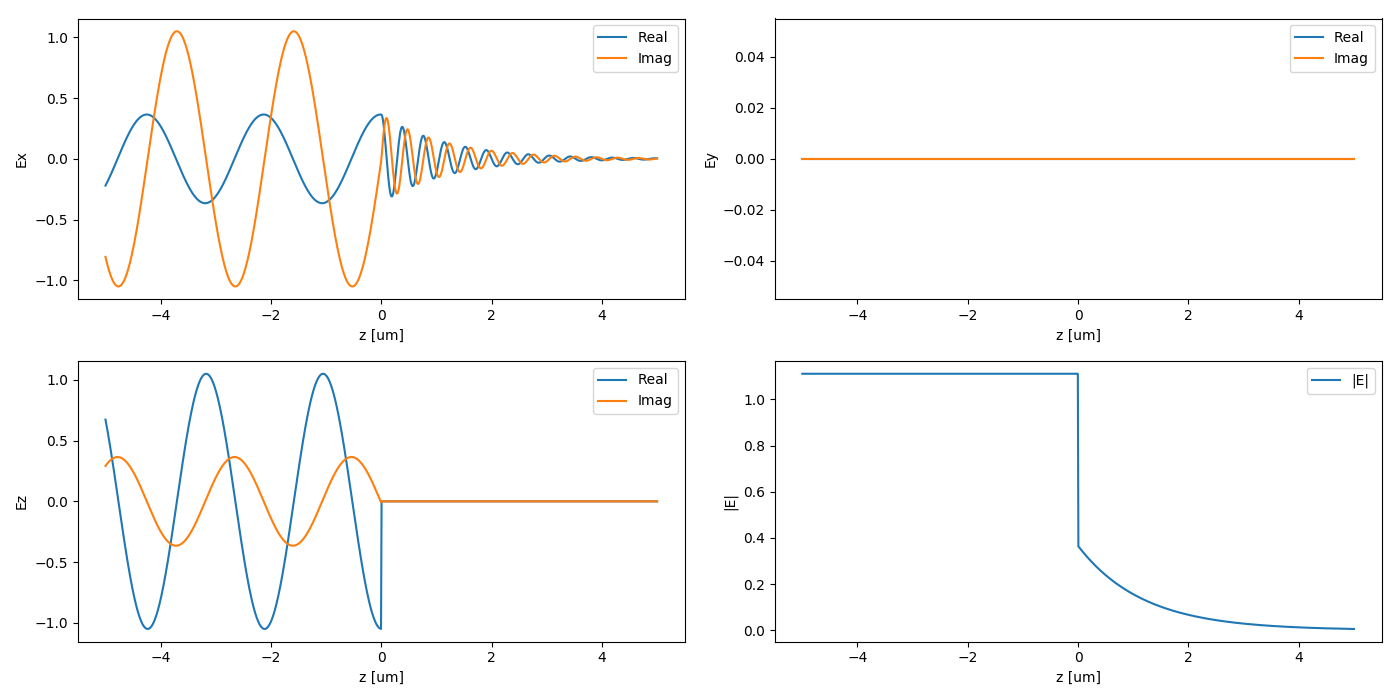

In [7]:
ongrid = True
z_vals = np.linspace(-5, 5, 1000)
Ex = np.zeros_like(z_vals, dtype=np.complex)
Ey = np.zeros_like(z_vals, dtype=np.complex)
Ez = np.zeros_like(z_vals, dtype=np.complex)
for i, z in enumerate(z_vals):
    if ongrid:
        E, H = sim.GetFieldsOnGrid(z=z, NumSamples=(25, 25), Format='Array')
        Ex[i] = E[0][0][0]
        Ey[i] = E[0][0][1]
        Ez[i] = E[0][0][2]
    else:
        E, H = sim.GetFields(0, 0, z)
        Ex[i] = E[0]
        Ey[i] = E[1]
        Ez[i] = E[2]
fig, axes = plt.subplots(2, 2, figsize=(14, 7))
ax1, ax2, ax3, ax4 = axes.flatten()
ax1.plot(z_vals, Ex.real, label = "Real")
ax1.plot(z_vals, Ex.imag, label = "Imag")
ax1.set_ylabel('Ex')
ax1.set_xlabel('z [um]')
ax1.legend()
ax2.plot(z_vals, Ey.real, label = "Real")
ax2.plot(z_vals, Ey.imag, label = "Imag")
ax2.set_ylabel('Ey')
ax2.set_xlabel('z [um]')
ax2.legend()
ax3.plot(z_vals, Ez.real, label = "Real")
ax3.plot(z_vals, Ez.imag, label = "Imag")
ax3.set_ylabel('Ez')
ax3.set_xlabel('z [um]')
ax3.legend()
normE = np.sqrt(np.absolute(Ex)**2 + np.absolute(Ey)**2 + np.absolute(Ez)**2)
ax4.plot(z_vals, normE, label = "|E|")
ax4.legend()
ax4.set_ylabel('|E|')
ax4.set_xlabel('z [um]')
plt.tight_layout()
plt.show()

Next step is to set up the analytic equations. These results are just straight up copied from Griffiths, for
arbitary angle of incidence.

First, the velocity of the wave in the slab must be

\begin{equation}
    v_{slab} = \frac{c}{n_{slab}}
\end{equation}

Snell's law tells use the relationship between the incident angle and the transmitted angle

\begin{equation}
    \frac{\sin(\theta_T)}{\sin(\theta_I)} = \frac{n_1}{n_2}
\end{equation}

Griffiths then defines some constants

\begin{align}
    \alpha &= \frac{\cos(\theta_T)}{\cos(\theta_I)} \\
    \beta &= \frac{\mu_1 n_2}{\mu_2 n_1}
\end{align}

In our case $\mu_1 = \mu_2 = \mu_0$ for simplicity (the slab is non magnetic)

Now we can compute the amplitudes of the reflected and transmitted waves analytically in terms of the incident amplitude

\begin{align}
    E_{0, R} &= \frac{\alpha - \beta}{\alpha + \beta} E_{0, I} \\ 
    E_{0, T} &= \frac{2}{\alpha + \beta} E_{0, I} \\ 
\end{align}

I write a function to compute and return the analytic waves given the necessary parameters below.

In [8]:
def analytic_waves(SI_freq, n_slab, Einc, z_vals, polar_angle):
    # polar_angle must be in radians!!
    # Define constants and scalar magnitudes of vectors
    si_omega = 2*np.pi*SI_freq
    theta_T = np.arcsin((1/n_slab)*np.sin(polar_angle))
    beta = n_slab
    alpha = np.cos(theta_T)/np.cos(polar_angle)
    v_slab = 1e6*consts.c / n_slab
    ktrans = si_omega / v_slab
    kinc = si_omega / (1e6*consts.c)
    kref = kinc
    Eref = Einc*(alpha - beta)/(alpha + beta)
    Etrans = Einc*2/(alpha + beta)
    # Define vector amplitudes and wave vectors
    vEinc = Einc*np.array([np.cos(polar_angle), 0, -np.sin(polar_angle)])
    vkinc = kinc*np.array([np.sin(polar_angle), 0, np.cos(polar_angle)])
    vEtrans = Etrans*np.array([np.cos(theta_T), 0, -np.sin(theta_T)])
    vktrans = ktrans*np.array([np.sin(theta_T), 0, np.cos(theta_T)])
    vEref = Eref*np.array([np.cos(polar_angle), 0, np.sin(polar_angle)])
    vkref = kref*np.array([np.sin(polar_angle), 0, -np.cos(polar_angle)])
    # Define 3D positions
    r_vals = np.zeros((z_vals.shape[0], 3))
    r_vals[:, 2] = z_vals
    # Get phases
    inc_phase = np.exp(1j*np.dot(r_vals, vkinc))
    ref_phase = np.exp(1j*np.dot(r_vals, vkref))
    trans_phase = np.exp(1j*np.dot(r_vals, vktrans))
    inc_wave = vEinc*np.column_stack((inc_phase, inc_phase, inc_phase))
    ref_wave = vEref*np.column_stack((ref_phase, ref_phase, ref_phase))
    trans_wave = vEtrans*np.column_stack((trans_phase, trans_phase, trans_phase))
    air_wave = inc_wave + ref_wave
    ind_arr = np.where(z_vals < 0)
    total_wave = np.zeros_like(inc_wave)
    total_wave[ind_arr, :] = air_wave[ind_arr, :]
    ind_arr = np.where(z_vals >= 0)
    total_wave[ind_arr, :] = trans_wave[ind_arr, :]
    Ex = total_wave[:,0]
    Ey = total_wave[:,1]
    Ez = total_wave[:,2]
    return Ex, Ey, Ez 

In [9]:
aEx, aEy, aEz = analytic_waves(SI_freq, n_slab, incident_amp, z_vals, polar_angle)

<IPython.core.display.Javascript object>


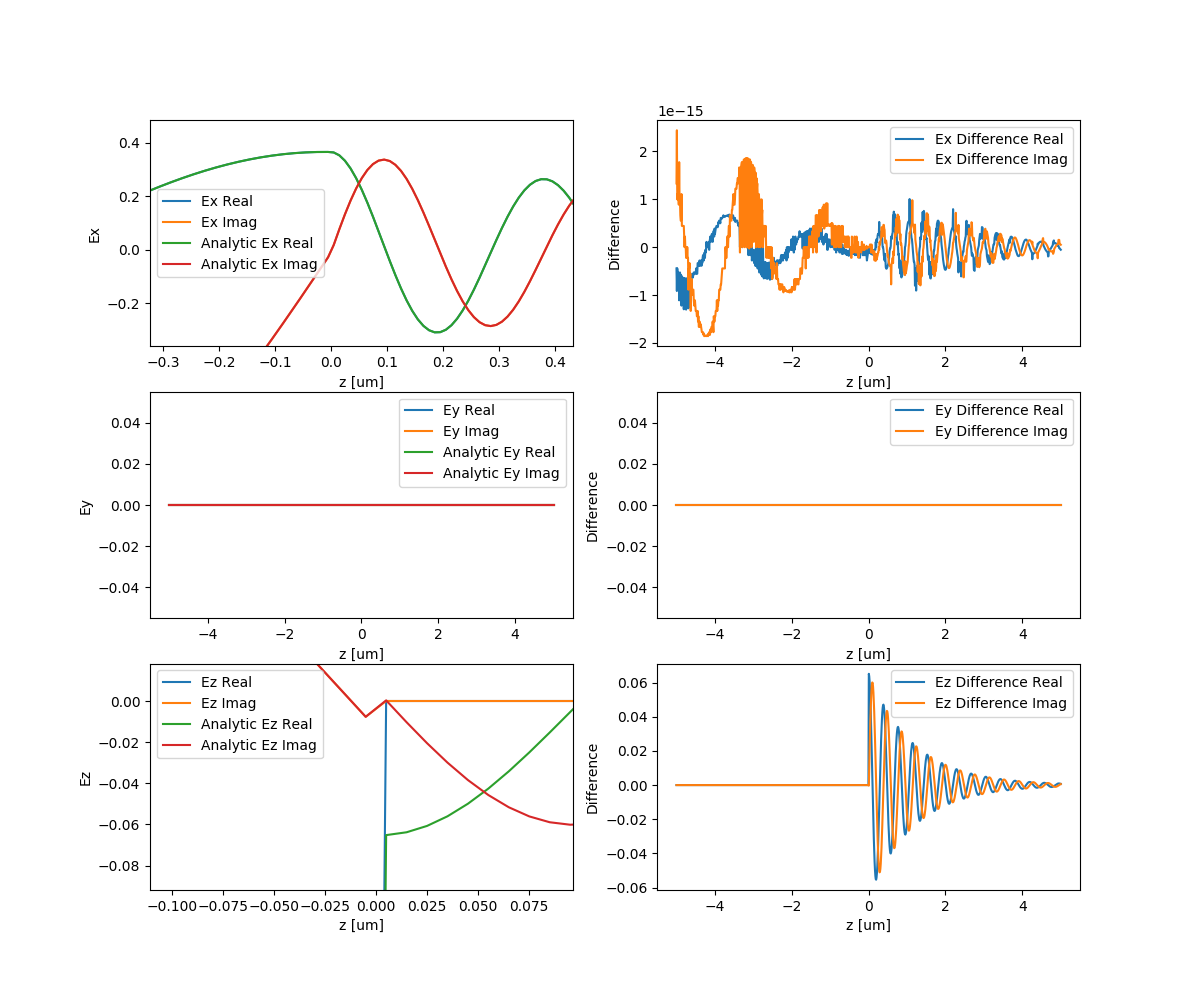

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
for i, comp in enumerate([(Ex, aEx, 'Ex'), (Ey, aEy, 'Ey'), (Ez, aEz, 'Ez')]):
    numeric_result = comp[0]
    analytic_result = comp[1]
    lab = comp[2]
    diff = numeric_result - analytic_result
    axes[i, 0].plot(z_vals, numeric_result.real, label="%s Real"%lab)
    axes[i, 0].plot(z_vals, numeric_result.imag, label="%s Imag"%lab)
    axes[i, 0].plot(z_vals, analytic_result.real, label="Analytic %s Real"%lab)
    axes[i, 0].plot(z_vals, analytic_result.imag, label="Analytic %s Imag"%lab)
    axes[i, 0].set_xlabel('z [um]')
    axes[i, 0].set_ylabel(lab)
    axes[i, 0].legend()
    axes[i, 1].plot(z_vals, diff.real, label="%s Difference Real"%lab)
    axes[i, 1].plot(z_vals, diff.imag, label="%s Difference Imag"%lab)
    axes[i, 1].set_xlabel('z [um]')
    axes[i, 1].set_ylabel('Difference')
    axes[i, 1].legend()
plt.show()

So it seems like the electric fields returned by S4 are indeed in SI units (Volts/meter). 

We can now compare the power per unit area of the incident, reflected, and transmitted waves to the results of the
`GetPowerFlux` function provided by S4. Analytically we have

\begin{align}
    S_{z,I} &= \frac{1}{2} \epsilon_1 v_1 E_{0,I}^2 \cos(\theta_I) \\
    S_{z,R} &= \frac{1}{2} \epsilon_1 v_1 E_{0,R}^2 \cos(\theta_I) \\
    S_{z,T} &= \frac{1}{2} \epsilon_2 v_2 E_{0,T}^2 \cos(\theta_T)
\end{align}

for monochromatic plane waves this value should be uniform over any x-y plane.

In [ ]:
def get_power_per_area(Einc, polar_angle, eps_vac, eps_slab, n_slab):
    #v_air = 1e6*consts.c
    v_air = consts.c
    Si = .5*consts.epsilon_0*eps_vac*v_air*np.absolute(Einc)**2*np.cos(polar_angle)
    theta_T = np.arcsin((1/n_slab)*np.sin(polar_angle))
    beta = n_slab
    alpha = np.cos(theta_T)/np.cos(polar_angle)
    v_slab = consts.c / n_slab
    Eref = Einc*(alpha - beta)/(alpha + beta)
    Etrans = Einc*2/(alpha + beta)
    Sr = .5*consts.epsilon_0*eps_vac*v_air*np.absolute(Eref)**2*np.cos(polar_angle)
    St = .5*consts.epsilon_0*eps_slab*v_slab*np.absolute(Etrans)**2*np.cos(theta_T)
    return Si, Sr, St

In [ ]:
nSi, nSr = sim.GetPowerFlux("VacuumAbove")
v_slab = consts.c / n_slab
print(nSi)
print(nSr)
nSt, nSr_slab = sim.GetPowerFlux("Slab", zOffset=.2)
print(nSt)
print(nSr_slab)
nSi = .5*consts.epsilon_0*eps_vac*consts.c*nSi
nSr = .5*consts.epsilon_0*eps_vac*consts.c*nSr
print(nSi)
print(nSr)
nSt = .5*consts.epsilon_0*eps_vac*consts.c*nSt
nSr = .5*consts.epsilon_0*eps_slab*v_slab*nSr
print(nSt)
print(nSr_slab)

In [ ]:
aSi, aSr, aSt = get_power_per_area(incident_amp, polar_angle, eps_vac, eps_slab, n_slab)
print(aSi)
print(aSr)
print(aSt)

Ok! So it seems like S4 is giving back only $|E|^2$ properly scaled by a cosine of the incident angle. It does this for the forward and
backward moving waves separately, which is shown in the calculation below. 

In [ ]:
Esq = np.absolute(Ex[0])**2 + np.absolute(Ey[0])**2 + np.absolute(Ez[0])**2
print(Esq*np.cos(polar_angle))
print(Esq*np.cos(polar_angle)-0.1654358085257486)
print(Esq)

Above, $|E|^2 = |E_{forw}|^2 + |E_{back}|^2$. In other words, the raw fields always contain the combination of forward and backward moving waves. By
subtracting out the backward moving intensity, we see the sum of the squares is equal to the incident intensity. This further confirms that the fields
are in SI units. So to fully clarify

GetPowerFlux = ($|E_{forw}|^2\cos(\theta_I), -|E_{back}|^2\cos(\theta_I)$)

When we multiply by the necessary
unitful constants, we get the z component of the Poynting vector which has units of power per unit area. For our case, we could just
multiply by the area of the unit cell to get the total power because the 
z-component of the Poynting flux is uniform over any x-y plane. However, what would the `GetPowerFlux` function return if $S_z$ was not uniform? 
Would it give me the average power per unit area, such that I could still just multiply by the area to get total power? Also, in a nonuniform
layer the constants out front become functions of space. What then? The power/area is a function of space, and we would need to perform an integral 
over the area to get at the total power.

So the question comes down to whether or not S4 is performing the integral over the area, then dividing by the area after the fact, or not
performing an integral at all. I think this could be clarified by simulating a nonuniform device below

# Slab with a Hole in It

In [ ]:
L = .75
numbasis = 200
sim = S4.New(Lattice=((L, 0), (0, L)), NumBasis=numbasis)
nn_slab = 4
k_slab = 0
eps_vac = complex(1, 0)
eps_slab = complex(nn_slab**2 - k_slab**2, 2*nn_slab*k_slab)
n_slab = complex(nn_slab, k_slab)
sim.SetMaterial(Name = "TestMaterial", Epsilon = eps_slab)
sim.SetMaterial(Name = "Vacuum", Epsilon = eps_vac)
sim.AddLayer(Name='VacuumAbove', Thickness = 0, Material='Vacuum')
sim.AddLayer(Name='Slab', Thickness = .5, Material='TestMaterial')
sim.SetRegionCircle(Layer="Slab", Material="Vacuum", Center=(0, 0), Radius=0.2)
# Tried both, makes no difference.
#sim.AddLayerCopy(Name="VacuumBelow", Thickness = 0, Layer="VacuumAbove")
sim.AddLayer(Name='VacuumBelow', Thickness = 0, Material='Vacuum')
SI_freq = 2e14 # Hertz
SI_wvlgth = 1e6*consts.c / SI_freq # micrometers
print(SI_wvlgth)
LH_freq = SI_freq/(consts.c * 1e6) # 1/micrometers
print(LH_freq)
sim.SetFrequency(LH_freq)
polar_angle = np.pi/4
incident_amp = complex(1, 0)
sim.SetExcitationPlanewave(IncidenceAngles=(np.rad2deg(polar_angle), 0), sAmplitude=complex(0, 0), pAmplitude=incident_amp)

In [ ]:
Si, Sr = sim.GetPowerFlux("VacuumAbove")
St, Sr_slab = sim.GetPowerFlux("Slab")
print(Si)
print(Sr)
print(St)
print(Sr_slab)

In [ ]:
xsamples = 300
ysamples = 300
E,H = sim.GetFieldsOnGrid(z = .1, NumSamples=(xsamples,ysamples), Format = 'Array')
E_arr = np.array(E)
H_arr = np.array(H)

In [ ]:
print(E_arr.shape)

In [ ]:
S = np.cross(E_arr, np.conj(H_arr))
Sz = S[:, :, 2]
plt.figure()
plt.imshow(Sz.real)
plt.colorbar()
plt.show()

In [ ]:
dx = L/xsamples
dy = L/ysamples
x_vals = np.arange(0, L, dx)
y_vals = np.arange(0, L, dy)
x_integral = intg.trapz(Sz, x=x_vals)
result = intg.trapz(x_integral, x=y_vals)
print(result/(L**2))
print(Si+Sr)
print(St+Sr_slab)

So it appears that `GetPowerFlux` is indeed performing the integral of the z-component of the Poynting flux over
the area of the unit cell, _but dividing by the area of the unit cell after integration_. I reached this conclusion based on the relatively 
good agreement between the explicit integration of the z-component of the Poytning flux constructed from the raw fields (divided by the area)
and the result of `GetPowerFlux`.

So I think what I need to do when computing the total power absorbed in a layer via the flux method is multiply everything
by the area of the unit cell. Then it should compare to the volume integration method.